In [1]:
from time import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif

In [4]:
# Data Loading
# train = '../../data/train/train.csv'
# test =  '../../data/test/test.csv'
# Data Pre-processing

data = pd.read_csv('train.csv', sep=",", header=None)
data2 = pd.read_csv('test.csv', sep=",", header=None)

print (data[:2])

X_train = data[1]
X_test = data2[1]
# print(data)
# print (X_test[:6])

         0                                                  1    2
0  id26305  This process, however, afforded me no means of...  EAP
1  id17569  It never once occurred to me that the fumbling...  HPL


In [11]:
labels_name = np.array(data[2]) 
le = preprocessing.LabelEncoder()
le.fit(labels_name)
list(le.classes_)

y_train = le.transform(labels_name)
list(le.inverse_transform(y_train[:4]))

# Cross Valifation code
#cv_X_train, cv_X_val, cv_y_train, cv_y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

# Extra stop words and punctuations removal
stopwords = {'hi','ha','I','we','is','a','an','the','this','me','of','that','A','in','they','to','by','his','her','he','she','it','you','are','we','they','for','was','were','by','and',',','!','hi','hu','Dr.','Mr.','Mrs.','say','said','was','.','"','oh','no','yes','their','them','any','do','now','as','be','D','as','all','do','such','with','as',';',':','?','see','how','M.','\'',''}
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stop_words, ngram_range=(1,2))
t_X_train = vectorizer.fit_transform(X_train)
t_X_test = vectorizer.fit_transform(X_test)


In [9]:
selector = SelectPercentile(f_classif, percentile=1)
selector.fit(t_X_train, y_train)
t_X_train = selector.transform(t_X_train)
t_X_test  = selector.transform(t_X_test)
print (len(t_X_test))

ValueError: X has a different shape than during fitting.

In [12]:
# Classifiers
clf_MNB = MultinomialNB(alpha=.107)
clf_xg = XGBClassifier(booster='gblinear', max_depth=5, n_jobs=-1)
reg_br = linear_model.LogisticRegression(C=1, max_iter=200, multi_class='multinomial', 
                                         intercept_scaling=3, solver='newton-cg')
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_svc = SVC(kernel='linear',degree=1, C=1, cache_size=10000, probability=True)
clf_dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
ada_clf = AdaBoostClassifier(clf_dt, learning_rate=0.1, n_estimators=10)

In [13]:
# (clf_svc, "Support Vector Classifier")
classifiers = [(clf_MNB, "MultinomialNB"), (clf_xg, "XGBoost"), (clf_rf, "RandomForest"), (clf_dt, "Decision Tree"), (ada_clf, "Decision Tree's AdaBoost")]
for clf, name in classifiers:
    pred = cross_val_predict(clf, t_X_train, y_train, cv = 6)
    accuracy = np.mean(pred == y_train)
    print (name, "'s Accuracy:", accuracy)

MultinomialNB 's Accuracy: 0.841411716635
XGBoost 's Accuracy: 0.781398437101
RandomForest 's Accuracy: 0.657643393432
Decision Tree 's Accuracy: 0.458756831299
Decision Tree's AdaBoost 's Accuracy: 0.514020123602


In [6]:
classifiers = [(reg_br, "Linear Regression"), (clf_MNB, "MultinomialNB"), (clf_xg, "XGBoost"), (clf_rf, "RandomForest"), (clf_dt, "Decision Tree"), (ada_clf, "Decision Tree's AdaBoost")]
X_tr, X_te, y_tr, y_te = train_test_split(t_X_train, y_train, test_size=.2, random_state=0)

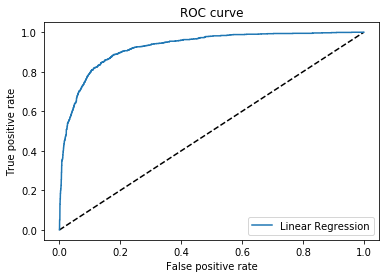

Area under curve for: Linear Regression 0.925302996297


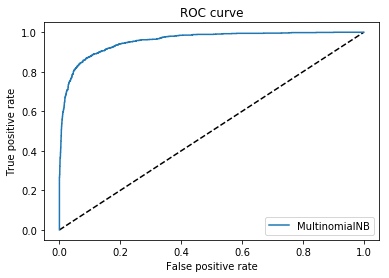

Area under curve for: MultinomialNB 0.956672916207


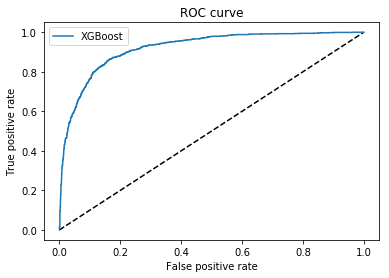

Area under curve for: XGBoost 0.919559094597


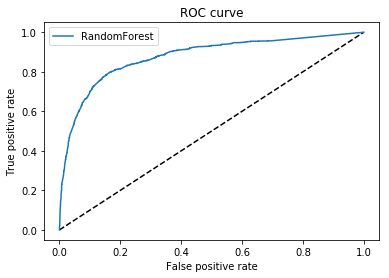

Area under curve for: RandomForest 0.875990316759


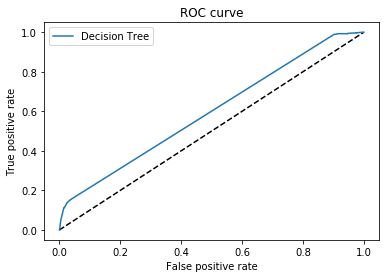

Area under curve for: Decision Tree 0.595600716924


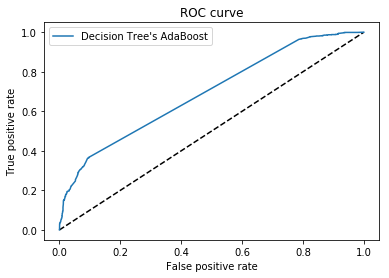

Area under curve for: Decision Tree's AdaBoost 0.692589038216


In [8]:
for clf, name in classifiers:
    classifier = OneVsRestClassifier(clf, n_jobs=3)
    y_score = classifier.fit(X_tr, y_tr).predict_proba(X_te)
    fpr, tpr, thresholds = roc_curve(y_te.ravel(), y_score[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print("Area under curve for:", name, roc_auc)

In [11]:
clf, name = (clf_svc, "Support Vector Classifier")
classifier = OneVsRestClassifier(clf, n_jobs=-1)
y_score = classifier.fit(X_tr, y_tr).predict_proba(X_te)

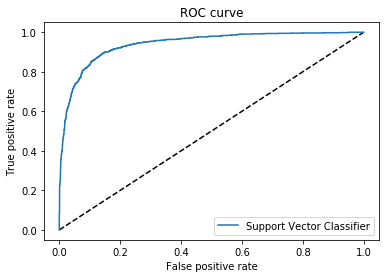

Area under curve for: Support Vector Classifier 0.940388638864


In [12]:
fpr, tpr, thresholds = roc_curve(y_te.ravel(), y_score[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=name)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("Area under curve for:", name, roc_auc)